In [3]:
import torch

# 广播(broadcasting mechanism)

In [ ]:
a = torch.arange(3).reshape((3,1))
b = torch.arange(2).reshape((1,2))

a, b
a + b

(tensor([[0],
         [1],
         [2]]),
 tensor([[0, 1]]))

In [27]:
a = torch.arange(6).reshape((2,3))
b = torch.arange(3).reshape((3))
c = a + b

a, b, c

(tensor([[0, 1, 2],
         [3, 4, 5]]),
 tensor([0, 1, 2]),
 tensor([[0, 2, 4],
         [3, 5, 7]]))

# 指针

In [28]:
before = id(a)
a = a + b
id(a) == before

False

In [47]:
z = torch.zeros_like(a)
z[:] = a + b


In [48]:
before = id(a)
a += b
id(a) == before

True

# 数据预处理

In [52]:
import os
os.makedirs(os.path.join('..','data'),exist_ok=True)
data_file = os.path.join('..','data','house_tiny.csv')
data_file
with open(data_file,'w') as f:
    f.write('NumRooms,Alley,Price\n')
    f.write('NA,Pave,127500\n')
    f.write('2,NA,106000\n')
    f.write('4,NA,178100\n')
    f.write('3,NA,140000\n')

In [ ]:
import pandas as pd

data = pd.read_csv(data_file)
data

,NumRooms,Alley,Price
0,NaN,Pave,127500
1,2.0,NaN,106000
2,4.0,NaN,178100
3,3.0,NaN,140000


为了处理缺失的数据，典型的方法包括差值和删除。

In [67]:
# 把NumRooms的缺失值替换为均值
data['NumRooms'] = data['NumRooms'].fillna(data['NumRooms'].mean())
data

,NumRooms,Alley,Price
0,3.0,Pave,127500
1,2.0,NaN,106000
2,4.0,NaN,178100
3,3.0,NaN,140000


In [71]:
inputs = pd.get_dummies(data, dummy_na=True)
inputs

,NumRooms,Price,Alley_Pave,Alley_nan
0,3.0,127500,True,False
1,2.0,106000,False,True
2,4.0,178100,False,True
3,3.0,140000,False,True


现在inputs和outputs条目都是数值类型，可以将它转换为张量格式。

In [ ]:
inputs = torch.tensor(inputs.values)

## 线性代数

### 矩阵

In [76]:
A = torch.arange(20).reshape(5,4)
A

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15],
        [16, 17, 18, 19]])

In [75]:
A.T

tensor([[ 0,  4,  8, 12, 16],
        [ 1,  5,  9, 13, 17],
        [ 2,  6, 10, 14, 18],
        [ 3,  7, 11, 15, 19]])

In [77]:
A*A

tensor([[  0,   1,   4,   9],
        [ 16,  25,  36,  49],
        [ 64,  81, 100, 121],
        [144, 169, 196, 225],
        [256, 289, 324, 361]])

In [78]:
A.sum()

tensor(190)

In [84]:
A_sum_axis1 = A.sum(axis=1)
print(A_sum_axis1)
print(A_sum_axis1.shape)

tensor([ 6, 22, 38, 54, 70])
torch.Size([5])


In [83]:
sum_A = A.sum(axis=1, keepdims=True)
sum_A

tensor([[ 6],
        [22],
        [38],
        [54],
        [70]])

点积

In [86]:
x = torch.arange(4, dtype=torch.float32)
y = torch.ones(4)
x, y, torch.dot(x, y)

(tensor([0., 1., 2., 3.]), tensor([1., 1., 1., 1.]), tensor(6.))

矩阵向量积

In [90]:
A = torch.arange(12).reshape(3,4)
x = torch.arange(4, dtype=torch.long)
A, x, torch.mv(A,x)

(tensor([[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11]]),
 tensor([0, 1, 2, 3]),
 tensor([14, 38, 62]))

矩阵相乘

In [91]:
B = torch.arange(20).reshape(4,5)
A, B, torch.mm(A,B)

(tensor([[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11]]),
 tensor([[ 0,  1,  2,  3,  4],
         [ 5,  6,  7,  8,  9],
         [10, 11, 12, 13, 14],
         [15, 16, 17, 18, 19]]),
 tensor([[ 70,  76,  82,  88,  94],
         [190, 212, 234, 256, 278],
         [310, 348, 386, 424, 462]]))

范数

In [92]:
u = torch.tensor([3.0,-4.0])
torch.norm(u)

tensor(5.)

## 自动求导
假设我们对函数 $y = 2x^Tx$,关于列向量x求导

In [122]:
x = torch.arange(4.0, requires_grad=True) # requires_grad表示需要一个地方来存储梯度
x.grad # 默认值为None

In [123]:
y = 2 * torch.dot(x, x)
y

tensor(28., grad_fn=<MulBackward0>)

通过反向传播来自动计算y关于x每个分量的梯度

In [124]:
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

In [125]:
x.grad == 4 * x

tensor([True, True, True, True])

现在让我们计算x的另一个函数
在默认情况下，PyTorch会累积梯度。因此，在执行新的反向传播之前，我们需要清除现有的梯度。

In [ ]:
x.grad.zero_()
y = x.sum()
y.backward()
x.grad

tensor(6., grad_fn=<SumBackward0>)
tensor(6., grad_fn=<SumBackward0>)


tensor([1., 1., 1., 1.])

## 线性回归

In [131]:
import random

根据带有噪声的线性模型生成一些数据样本

In [128]:
def synthetic_data(w, b, num_examples):
    """生成y = Xw + b + 噪声。"""
    X = torch.normal(0, 1, (num_examples, len(w))) # 均值为0，标准差为1
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
features.shape, labels.shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

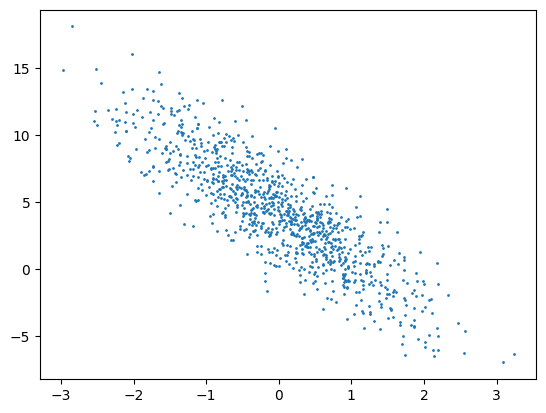

In [129]:
import matplotlib.pyplot as plt
plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

定义一个data_iter函数，接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量。

In [132]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples)) # 生成一个从0到num_examples-1的列表
    random.shuffle(indices)  # 打乱顺序
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.6815, -1.5796],
        [-1.0223, -0.1170],
        [ 0.8972, -0.4358],
        [-1.4181,  0.0924],
        [ 0.7100, -0.6363],
        [-0.0319,  0.6379],
        [ 0.3340,  0.4859],
        [-0.9242,  0.9631],
        [ 1.3637,  0.6176],
        [ 0.6686,  0.7012]]) 
 tensor([[10.9231],
        [ 2.5550],
        [ 7.4947],
        [ 1.0377],
        [ 7.7751],
        [ 1.9735],
        [ 3.2189],
        [-0.9186],
        [ 4.8510],
        [ 3.1520]])


定义初始化模型参数

In [133]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

定义模型

In [134]:
def linreg(X, w, b):
    """线性回归模型。"""
    return torch.matmul(X, w) + b

定义损失函数

In [135]:
def squared_loss(y_hat, y):
    """均方损失。"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

定义优化算法

In [136]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降。"""
    with torch.no_grad(): 
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

训练过程

In [137]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # 计算损失值
        l.sum().backward()         # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.031445
epoch 2, loss 0.000114
epoch 3, loss 0.000050


In [138]:
w, b

(tensor([[ 2.0005],
         [-3.3999]], requires_grad=True),
 tensor([4.1996], requires_grad=True))

## 线性回归的简洁实现

In [142]:
import numpy as np
from torch.utils import data

features, labels = synthetic_data(true_w, true_b, 1000)

In [143]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器。"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter))

[tensor([[-0.7271, -2.2295],
         [-0.7647, -0.0202],
         [-0.3336,  0.4085],
         [-0.0836,  0.2170],
         [ 3.4178, -0.9861],
         [-0.0744,  0.3137],
         [ 0.7642,  1.4739],
         [ 1.7870, -0.7930],
         [ 1.4198, -0.1644],
         [ 0.0572,  0.3642]]),
 tensor([[10.3362],
         [ 2.7347],
         [ 2.1555],
         [ 3.3008],
         [14.3998],
         [ 2.9806],
         [ 0.7193],
         [10.4815],
         [ 7.5854],
         [ 3.0859]])]

In [144]:
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

In [145]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [146]:
loss = nn.MSELoss()
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [ ]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {float(l.mean()):f}')

epoch 1, loss 0.000214
epoch 2, loss 0.000102
epoch 3, loss 0.000102
